In [1]:
import os
from shutil import copyfile, rmtree

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow


import warnings; warnings.simplefilter('ignore')

import PIL
from PIL import ImageDraw

%matplotlib inline

In [4]:
data_dir = "games_collected"

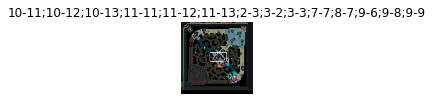

In [7]:
data = (ImageList.from_csv(data_dir+"/team", 'full_coordinates.csv', suffix='.png')
        .split_by_rand_pct()
        .label_from_df(label_delim=' ')
        .databunch(bs=128)
        .normalize(imagenet_stats))

data.show_batch(rows=1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


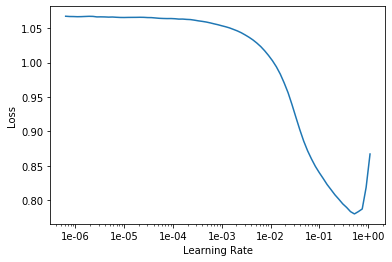

In [8]:
# learn.lr_find()
# learn.recorder.plot()

https://gilberttanner.com/blog/fastai-multi-label-image-classification

In [8]:
thresh = 0.2
acc_02 = partial(accuracy_thresh, thresh=thresh)
f_score = partial(fbeta, thresh=thresh)
learn = create_cnn(data, models.resnet50, metrics=[acc_02, f_score])
learn.callbacks = [SaveModelCallback(learn, every='improvement', mode='min', name='best')]
gc.collect()

2142

In [9]:
lr = 0.05
learn.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.202310,0.186097,0.917403,0.446757,02:00
1,0.177072,0.167986,0.914235,0.543548,01:55
2,0.163928,0.155677,0.919250,0.588318,01:55


Better model found at epoch 0 with valid_loss value: 0.18609733879566193.
Better model found at epoch 1 with valid_loss value: 0.16798590123653412.
Better model found at epoch 2 with valid_loss value: 0.15567654371261597.


In [10]:
learn.unfreeze()

In [11]:
learn.fit_one_cycle(10, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.159800,0.160945,0.920992,0.590691,02:30
1,0.160199,0.191115,0.916590,0.587840,02:30
2,0.158356,0.155939,0.912268,0.605635,02:31
3,0.153465,0.200213,0.922851,0.612886,02:29
4,0.146742,0.154363,0.929158,0.624605,02:30
5,0.140420,0.145662,0.927079,0.648263,02:33
6,0.133330,0.136055,0.931887,0.661170,02:34
7,0.125974,0.128250,0.932561,0.674093,02:32
8,0.119356,0.126213,0.934976,0.678195,02:28
9,0.115724,0.125932,0.934652,0.679635,02:28


Better model found at epoch 0 with valid_loss value: 0.16094522178173065.
Better model found at epoch 2 with valid_loss value: 0.15593861043453217.
Better model found at epoch 4 with valid_loss value: 0.15436315536499023.
Better model found at epoch 5 with valid_loss value: 0.145661860704422.
Better model found at epoch 6 with valid_loss value: 0.1360549032688141.
Better model found at epoch 7 with valid_loss value: 0.128249853849411.
Better model found at epoch 8 with valid_loss value: 0.1262134611606598.
Better model found at epoch 9 with valid_loss value: 0.12593211233615875.


### Results
* learn.fit_one_cycle(10, slice(1e-5, lr/5))
* 0.100947	0.109149	0.946151	0.642221	05:58

* learn.fit_one_cycle(10, slice(1e-5, lr/5))
* 0.115724 	0.125932 	0.934652 	0.679635 	02:28

In [12]:
preds = learn.get_preds(ds_type=DatasetType.Valid)

In [13]:
grid_size = 10
def draw_grid(draw, labels):
    fill = (0, 255, 255, 96)
    for l in labels:
        x = l[0] * grid_size
        y = l[1] * grid_size
        draw.rectangle((x, y, x + grid_size, y + grid_size), fill=fill)
        
def process(image):
    plt.figure()
    plt.imshow(image)
        
def draw_preds(index):
    p = preds[0][index]
    classes = [data.classes[i] for i in range(len(p)) if p[i] > thresh]
    classes = [(int(c.split("-")[0]), int(c.split("-")[1])) for c in classes]

    filename = learn.data.valid_ds.items[index]
    img = PIL.Image.open(filename)

    overlay = PIL.Image.new('RGBA', img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)
    draw_grid(draw, classes)
    out = PIL.Image.alpha_composite(img, overlay)

    process(out)
    filename =  filename.split("/")[-1]
    filename = data_dir+"/full/"+filename
    img = PIL.Image.open(filename)
    process(img)

In [41]:
k = 700

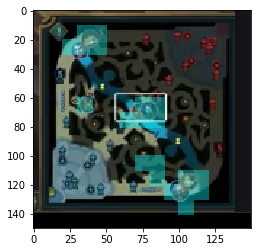

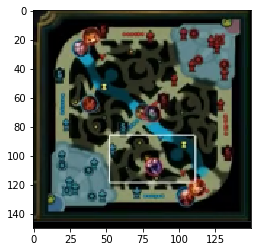

In [51]:
k += random.randint(10, 50)
draw_preds(k)

In [40]:
learn.export("models/predict.pth")